In [ ]:
!pip install lifelines

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.7/350.7 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.0/91.0 kB 7.8 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=c6af5a63deafe50e93375fb5890cfaec48b2adf52dc7c73b2a4e48c6431a0868
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import random
import lifelines
import itertools
#from public_tests import *

plt.rcParams['figure.figsize'] = [10, 7]

In [ ]:
data = pd.read_csv("/content/levamisole_data.csv", index_col=0)

In [ ]:
print(f"Data Dimensions: {data.shape}")
data.head()

Data Dimensions: (607, 14)


,sex,age,obstruct,perfor,adhere,nodes,node4,outcome,TRTMT,differ_2.0,differ_3.0,extent_2,extent_3,extent_4
1,1,43,0,0,0,5.0,1,1,True,1,0,0,1,0
2,1,63,0,0,0,1.0,0,0,True,1,0,0,1,0
3,0,71,0,0,1,7.0,1,1,False,1,0,1,0,0
4,0,66,1,0,0,6.0,1,1,True,1,0,0,1,0
5,1,69,0,0,0,22.0,1,1,False,1,0,0,1,0


In [ ]:
def proportion_treated(df):
    """
    Compute proportion of trial participants who have been treated

    Args:
        df (dataframe): dataframe containing trial results. Column
                      'TRTMT' is 1 if patient was treated, 0 otherwise.

    Returns:
        result (float): proportion of patients who were treated
    """

    proportion = sum(df.TRTMT==1)/len(df.TRTMT)


    return proportion

In [ ]:
print("dataframe:\n")
example_df = pd.DataFrame(data =[[0, 0],
                                 [1, 1],
                                 [1, 1],
                                 [1, 1]], columns = ['outcome', 'TRTMT'])
print(example_df)
print("\n")
treated_proportion = proportion_treated(example_df)
print(f"Proportion of patient treated: computed {treated_proportion}, expected: 0.75")

dataframe:

   outcome  TRTMT
0        0      0
1        1      1
2        1      1
3        1      1


Proportion of patient treated: computed 0.75, expected: 0.75


In [ ]:
p = proportion_treated(data)
print(f"Proportion Treated: {p} ~ {int(p*100)}%")

Proportion Treated: 0.49093904448105435 ~ 49%


In [ ]:
def event_rate(df):
    '''
    Compute empirical rate of death within 5 years
    for treated and untreated groups.

    Args:
        df (dataframe): dataframe containing trial results.
                          'TRTMT' column is 1 if patient was treated, 0 otherwise.
                            'outcome' column is 1 if patient died within 5 years, 0 otherwise.

    Returns:
        treated_prob (float): empirical probability of death given treatment
        untreated_prob (float): empirical probability of death given control
    '''

    treated_prob = 0.0
    control_prob = 0.0

    treated_prob = sum((df.TRTMT == 1) & (df.outcome == 1)) / sum((df.TRTMT == 1))
    control_prob = sum((df.TRTMT == 0) & (df.outcome == 1)) / sum((df.TRTMT == 0))


    return treated_prob, control_prob

In [ ]:
print("TEST CASE\ndataframe:\n")
example_df = pd.DataFrame(data =[[0, 1],
                                 [1, 1],
                                 [1, 1],
                                 [0, 1],
                                 [1, 0],
                                 [1, 0],
                                 [1, 0],
                                 [0, 0]], columns = ['outcome', 'TRTMT'])
#print("dataframe:\n")
print(example_df)
print("\n")
treated_prob, control_prob = event_rate(example_df)
print(f"Treated 5-year death rate, expected: 0.5, got: {treated_prob:.4f}")
print(f"Control 5-year death rate, expected: 0.75, got: {control_prob:.4f}")

TEST CASE
dataframe:

   outcome  TRTMT
0        0      1
1        1      1
2        1      1
3        0      1
4        1      0
5        1      0
6        1      0
7        0      0


Treated 5-year death rate, expected: 0.5, got: 0.5000
Control 5-year death rate, expected: 0.75, got: 0.7500


In [ ]:
treated_prob, control_prob = event_rate(data)

print(f"Death rate for treated patients: {treated_prob:.4f} ~ {int(treated_prob*100)}%")
print(f"Death rate for untreated patients: {control_prob:.4f} ~ {int(control_prob*100)}%")

Death rate for treated patients: 0.3725 ~ 37%
Death rate for untreated patients: 0.4822 ~ 48%


In [ ]:
from sklearn.model_selection import train_test_split
np.random.seed(18)
random.seed(1)

data = data.dropna(axis=0)
y = data.outcome

X = data.drop('outcome', axis=1)
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size = 0.25, random_state=0)

In [ ]:
print(f"dev set shape: {X_dev.shape}")
print(f"test set shape: {X_test.shape}")

dev set shape: (455, 13)
test set shape: (152, 13)


In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l2',solver='lbfgs', max_iter=10000).fit(X_dev, y_dev)

In [ ]:
def extract_treatment_effect(lr, data):
    theta_TRTMT = 0.0
    TRTMT_OR = 0.0
    coeffs = {data.columns[i]:lr.coef_[0][i] for i in range(len(data.columns))}

    # get the treatment coefficient
    theta_TRTMT = coeffs['TRTMT']

    # calculate the Odds ratio for treatment
    TRTMT_OR = np.exp(theta_TRTMT)

    return theta_TRTMT, TRTMT_OR

In [ ]:
theta_TRTMT, trtmt_OR = extract_treatment_effect(lr, X_dev)
print(f"Theta_TRTMT: {theta_TRTMT:.4f}")
print(f"Treatment Odds Ratio: {trtmt_OR:.4f}")

Theta_TRTMT: -0.2886
Treatment Odds Ratio: 0.7493


In [ ]:
def OR_to_ARR(p, OR):
    """
    Compute ARR for treatment for individuals given
    baseline risk and odds ratio of treatment.

    Args:
        p (float): baseline probability of risk (without treatment)
        OR (float): odds ratio of treatment versus baseline

    Returns:
        ARR (float): absolute risk reduction for treatment
      """

    # compute baseline odds from p
    odds_baseline = p/(1-p)

    # compute odds of treatment using odds ratio
    odds_trtmt = OR*odds_baseline

    # compute new probability of death from treatment odds
    p_trtmt = odds_trtmt/(1+odds_trtmt)

    # compute ARR using treated probability and baseline probability
    ARR = p - p_trtmt

    return ARR

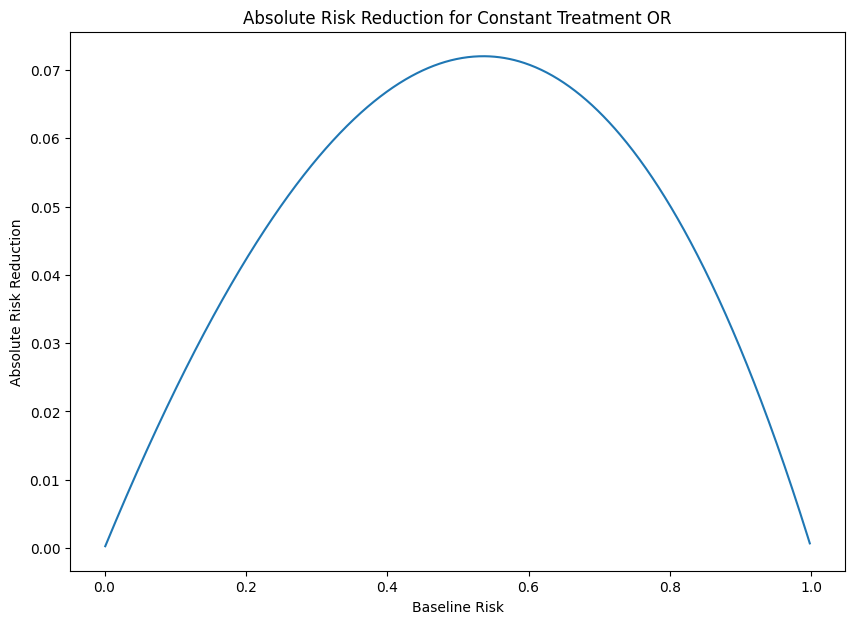

In [ ]:
ps = np.arange(0.001, 0.999, 0.001)
diffs = [OR_to_ARR(p, trtmt_OR) for p in ps]
plt.plot(ps, diffs)
plt.title("Absolute Risk Reduction for Constant Treatment OR")
plt.xlabel('Baseline Risk')
plt.ylabel('Absolute Risk Reduction')
plt.show()

In [ ]:
def base_risks(X, lr_model):
    """
    Compute baseline risks for each individual in X.

    Args:
        X (dataframe): data from trial. 'TRTMT' column
                       is 1 if subject retrieved treatment, 0 otherwise
        lr_model (model): logistic regression model

    Returns:
        risks (np.array): array of predicted baseline risk
                          for each subject in X
    """

    # first make a copy of the dataframe so as not to overwrite the original
    X = X.copy(deep=True)

    # Set the treatment variable to assume that the patient did not receive treatment
    X.TRTMT = False

    # Input the features into the model, and predict the probability of death.
    risks = lr_model.predict_proba(X)[:,1]

    return risks

In [ ]:
def lr_ARR_quantile(X, y, lr):

    # first make a deep copy of the features dataframe to calculate the base risks
    X = X.copy(deep=True)

    # Make another deep copy of the features dataframe to store baseline risk, risk_group, and y
    df = X.copy(deep=True)

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    # Calculate the baseline risks (use the function that you just implemented)
    baseline_risk = base_risks(df.copy(deep=True), lr)

    # bin patients into 10 risk groups based on their baseline risks
    risk_groups = pd.cut(baseline_risk,10)

    # Store the baseline risk, risk_groups, and y into the new dataframe
    df.loc[:, 'baseline_risk'] = baseline_risk
    df.loc[:, 'risk_group'] = risk_groups
    df.loc[:, 'y'] = y_dev

    # select the subset of patients who did not actually receive treatment
    df_baseline = df[df.TRTMT==False]

    # select the subset of patients who did actually receive treatment
    df_treatment = df[df.TRTMT==True]

    # For baseline patients, group them by risk group, select their outcome 'y', and take the mean
    baseline_mean_by_risk_group = df_baseline.groupby('risk_group')['y'].mean()

    # For treatment patients, group them by risk group, select their outcome 'y', and take the mean
    treatment_mean_by_risk_group = df_treatment.groupby('risk_group')['y'].mean()

    # Calculate the absolute risk reduction by risk group (baseline minus treatment)
    arr_by_risk_group = baseline_mean_by_risk_group - treatment_mean_by_risk_group

    # Set the index of the arr_by_risk_group dataframe to the average baseline risk of each risk group
    # Use data for all patients to calculate the average baseline risk, grouped by risk group.
    arr_by_risk_group.index = df.groupby('risk_group')['baseline_risk'].mean()

    ### END CODE HERE ###

    # Set the name of the Series to 'ARR'
    arr_by_risk_group.name = 'ARR'

    return arr_by_risk_group

In [ ]:
abs_risks = lr_ARR_quantile(X_dev, y_dev, lr)

# print the Series
print(abs_risks)

baseline_risk
0.231680    0.089744
0.314204    0.042857
0.386420   -0.014604
0.459669    0.138889
0.532881    0.083333
0.627058   -0.104072
0.693463    0.150000
0.777251    0.293706
0.836416    0.083333
0.918760    0.200000
Name: ARR, dtype: float64


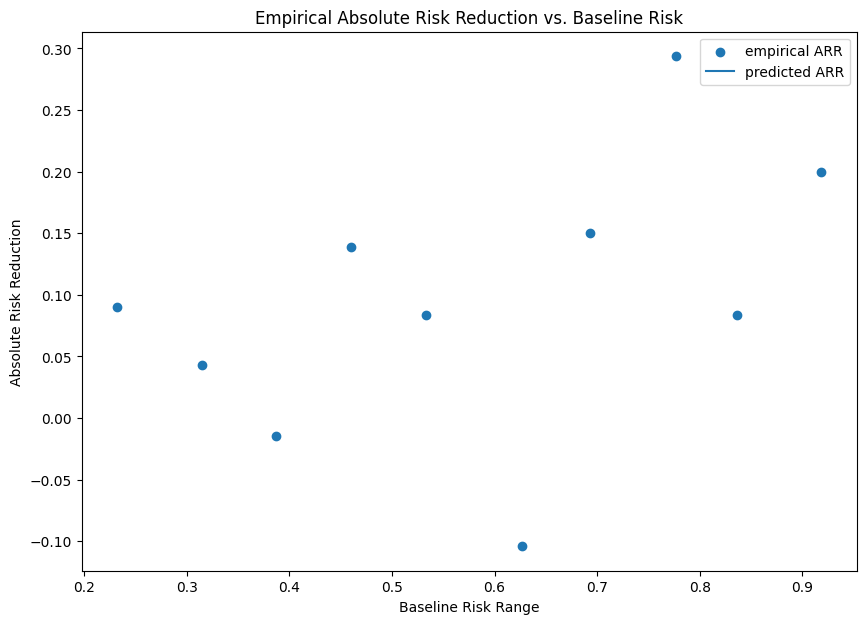

In [ ]:
plt.scatter(abs_risks.index, abs_risks, label='empirical ARR')
plt.title("Empirical Absolute Risk Reduction vs. Baseline Risk")
plt.ylabel("Absolute Risk Reduction")
plt.xlabel("Baseline Risk Range")
ps = np.arange(abs_risks.index[0]-0.05, abs_risks.index[-1]+0.05, 0.01)
diffs = [OR_to_ARR(p, trtmt_OR) for p in ps]
plt.plot(ps, diffs, label='predicted ARR')
plt.legend(loc='upper right')
plt.show()

In [ ]:
def c_for_benefit_score(pairs):
    """
    Compute c-statistic-for-benefit given list of
    individuals matched across treatment and control arms.

    Args:
        pairs (list of tuples): each element of the list is a tuple of individuals,
                                the first from the control arm and the second from
                                the treatment arm. Each individual
                                p = (pred_outcome, actual_outcome) is a tuple of
                                their predicted outcome and actual outcome.
    Result:
        cstat (float): c-statistic-for-benefit computed from pairs.
    """

    # mapping pair outcomes to benefit
    obs_benefit_dict = {
        (0, 0): 0,
        (0, 1): -1,
        (1, 0): 1,
        (1, 1): 0,
    }

    # compute observed benefit for each pair
    obs_benefit = [obs_benefit_dict[(i[1],j[1])] for (i,j) in pairs]

    # compute average predicted benefit for each pair
    pred_benefit = [np.mean([i[0],j[0]]) for (i,j) in pairs]

    concordant_count, permissible_count, risk_tie_count = 0, 0, 0

    # iterate over pairs of pairs
    for i in range(len(pairs)):
      for j in range(i + 1, len(pairs)):

            # if the observed benefit is different, increment permissible count
            if obs_benefit[i] != obs_benefit[j]:

                # increment count of permissible pairs
                permissible_count = permissible_count + 1

                # if concordant, increment count
                concordance= ((pred_benefit[i]>pred_benefit[j] and obs_benefit[i]>obs_benefit[j]) or (pred_benefit[i]<pred_benefit[j] and obs_benefit[i]<obs_benefit[j]))

                if (concordance): # change to check for concordance

                    concordant_count = concordant_count + 1

                # if risk tie, increment count
                if (pred_benefit[i]==pred_benefit[j]): #change to check for risk ties
                    risk_tie_count = risk_tie_count + 1


    # compute c-statistic-for-benefit
    cstat = (concordant_count + (0.5 * risk_tie_count)) / permissible_count

    return cstat

In [ ]:
def c_statistic(pred_rr, y, w, random_seed=0):
    """
    Return concordance-for-benefit, the proportion of all matched pairs with
    unequal observed benefit, in which the patient pair receiving greater
    treatment benefit was predicted to do so.

    Args:
        pred_rr (array): array of predicted risk reductions
        y (array): array of true outcomes
        w (array): array of true treatments

    Returns:
        cstat (float): calculated c-stat-for-benefit
    """
    assert len(pred_rr) == len(w) == len(y)
    random.seed(random_seed)

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    # Collect pred_rr, y, and w into tuples for each patient
    tuples = list(zip(pred_rr,y,w))

    # Collect untreated patient tuples, stored as a list
    untreated = list(filter(lambda x:x[2]==True, tuples))

    # Collect treated patient tuples, stored as a list
    treated = list(filter(lambda x:x[2]==False, tuples))

    # randomly subsample to ensure every person is matched

    # if there are more untreated than treated patients,
    # randomly choose a subset of untreated patients, one for each treated patient.

    if len(treated) < len(untreated):
        untreated = random.sample(untreated,k=len(treated))

    # if there are more treated than untreated patients,
    # randomly choose a subset of treated patients, one for each treated patient.
    if len(untreated) < len(treated):
        treated = random.sample(treated,k=len(untreated))

    assert len(untreated) == len(treated)

    # Sort the untreated patients by their predicted risk reduction
    untreated = sorted(untreated,key=lambda x:x[0])

    # Sort the treated patients by their predicted risk reduction
    treated = sorted(treated,key=lambda x:x[0])

    # match untreated and treated patients to create pairs together
    pairs = list(zip(treated,untreated))

    # calculate the c-for-benefit using these pairs (use the function that you implemented earlier)
    cstat = c_for_benefit_score(pairs)

    return cstat

In [ ]:
def treatment_control(X):
    """Create treatment and control versions of data"""
    X_treatment = X.copy(deep=True)
    X_control = X.copy(deep=True)
    X_treatment.loc[:, 'TRTMT'] = 1
    X_control.loc[:, 'TRTMT'] = 0
    return X_treatment, X_control

def risk_reduction(model, data_treatment, data_control):
    """Compute predicted risk reduction for each row in data"""
    treatment_risk = model.predict_proba(data_treatment)[:, 1]
    control_risk = model.predict_proba(data_control)[:, 1]
    return control_risk - treatment_risk

In [ ]:
X_test_treated, X_test_untreated = treatment_control(X_test)
rr_lr = risk_reduction(lr, X_test_treated, X_test_untreated)

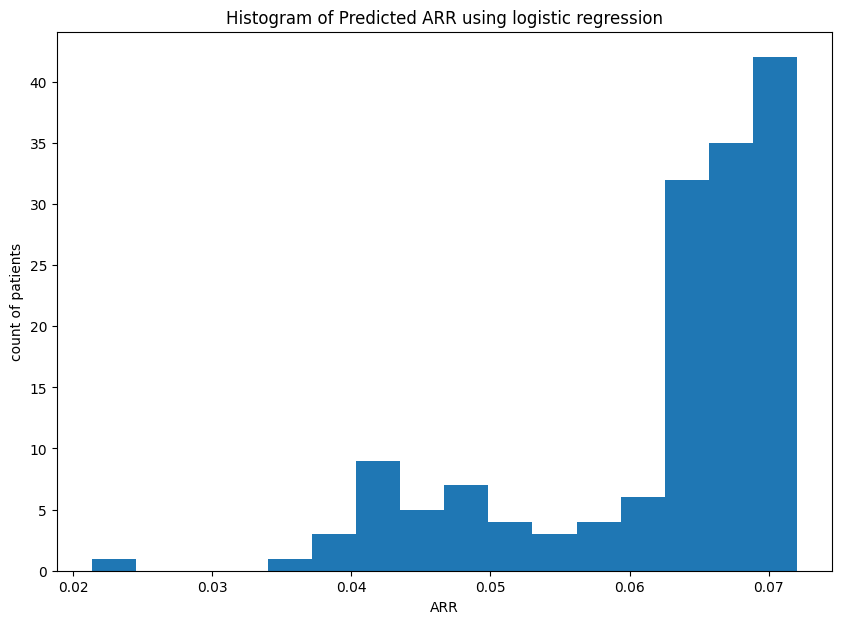

In [ ]:
plt.hist(rr_lr, bins='auto')
plt.title("Histogram of Predicted ARR using logistic regression")
plt.ylabel("count of patients")
plt.xlabel("ARR")
plt.show()

In [ ]:
tmp_cstat_test = c_statistic(rr_lr, y_test, X_test.TRTMT)
print(f"Logistic Regression evaluated by C-for-Benefit: {tmp_cstat_test:.4f}")

Logistic Regression evaluated by C-for-Benefit: 0.5440


In [ ]:
from lifelines.utils import concordance_index
tmp_regular_cindex = concordance_index(y_test, lr.predict_proba(X_test)[:, 1])
print(f"Logistic Regression evaluated by regular C-index: {tmp_regular_cindex:.4f}")

Logistic Regression evaluated by regular C-index: 0.7783


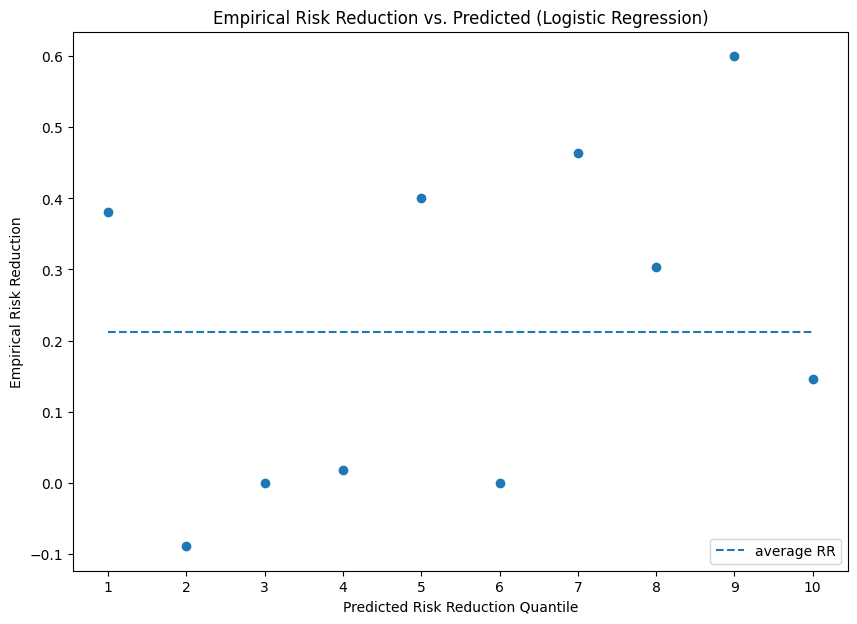

In [ ]:
def quantile_benefit(X, y, arr_hat):
    df = X.copy(deep=True)
    df.loc[:, 'y'] = y
    df.loc[:, 'benefit'] = arr_hat
    benefit_groups = pd.qcut(arr_hat, 10)
    df.loc[:, 'benefit_groups'] = benefit_groups
    empirical_benefit = df.loc[df.TRTMT == 0, :].groupby('benefit_groups').y.mean() - df.loc[df.TRTMT == 1].groupby('benefit_groups').y.mean()
    avg_benefit = df.loc[df.TRTMT == 0, :].y.mean() - df.loc[df.TRTMT==1, :].y.mean()
    return empirical_benefit, avg_benefit

def plot_empirical_risk_reduction(emp_benefit, av_benefit, model):
    plt.scatter(range(len(emp_benefit)), emp_benefit)
    plt.xticks(range(len(emp_benefit)), range(1, len(emp_benefit) + 1))
    plt.title("Empirical Risk Reduction vs. Predicted ({})".format(model))
    plt.ylabel("Empirical Risk Reduction")
    plt.xlabel("Predicted Risk Reduction Quantile")
    plt.plot(range(10), [av_benefit]*10, linestyle='--', label='average RR')
    plt.legend(loc='lower right')
    plt.show()

emp_benefit, avg_benefit = quantile_benefit(X_test, y_test, rr_lr)
plot_empirical_risk_reduction(emp_benefit, avg_benefit, "Logistic Regression")

In [ ]:
class TLearner():
    """
    T-Learner class.

    Attributes:
      treatment_estimator (object): fitted model for treatment outcome
      control_estimator (object): fitted model for control outcome
    """
    def __init__(self, treatment_estimator, control_estimator):
        """
        Initializer for TLearner class.
        """
        ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
        # set the treatment estimator
        self.treatment_estimator = treatment_estimator

        # set the control estimator
        self.control_estimator = control_estimator

        ### END CODE HERE ###

    def predict(self, X):
        """
        Return predicted risk reduction for treatment for given data matrix.

        Args:
          X (dataframe): dataframe containing features for each subject

        Returns:
          preds (np.array): predicted risk reduction for each row of X
        """
        ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
        # predict the risk of death using the control estimator
        risk_control = self.control_estimator.predict_proba(X)[:,1]

        # predict the risk of death using the treatment estimator
        risk_treatment = self.treatment_estimator.predict_proba(X)[:,1]

        # the predicted risk reduction is control risk minus the treatment risk
        pred_risk_reduction =  risk_control - risk_treatment


        return pred_risk_reduction

In [ ]:
def holdout_grid_search(clf, X_train_hp, y_train_hp, X_val_hp, y_val_hp, hyperparam, verbose=False):
    '''
    Conduct hyperparameter grid search on hold out validation set. Use holdout validation.
    Hyperparameters are input as a dictionary mapping each hyperparameter name to the
    range of values they should iterate over. Use the cindex function as your evaluation
    function.

    Input:
        clf: sklearn classifier
        X_train_hp (dataframe): dataframe for training set input variables
        y_train_hp (dataframe): dataframe for training set targets
        X_val_hp (dataframe): dataframe for validation set input variables
        y_val_hp (dataframe): dataframe for validation set targets
        hyperparam (dict): hyperparameter dictionary mapping hyperparameter
                                                names to range of values for grid search

    Output:
        best_estimator (sklearn classifier): fitted sklearn classifier with best performance on
                                                                                 validation set
    '''
    # Initialize best estimator
    best_estimator = None

    # initialize best hyperparam
    best_hyperparam = {}

    # initialize the c-index best score to zero
    best_score = 0.0

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

    # Get the values of the hyperparam and store them as a list of lists
    hyper_param_l = list(hyperparam.values())

    # Generate a list of tuples with all possible combinations of the hyperparams
    combination_l_of_t = list(itertools.product(*hyper_param_l))

    # Initialize the list of dictionaries for all possible combinations of hyperparams
    combination_l_of_d = []

    # loop through each tuple in the list of tuples
    for val_tuple in combination_l_of_t: # complete this line
        param_d = {}

        # Enumerate each key in the original hyperparams dictionary
        for i, k in enumerate(hyperparam): # complete this line

            # add a key value pair to param_dict for each value in val_tuple
            param_d[k] = val_tuple[i]

        # append the param_dict to the list of dictionaries
        combination_l_of_d.append(param_d)


    # For each hyperparam dictionary in the list of dictionaries:
    for param_d in combination_l_of_d: # complete this line

        # Set the model to the given hyperparams
        estimator = clf(**param_d)

        # Train the model on the training features and labels
        estimator.fit(X_train_hp,y_train_hp)

        # Predict the risk of death using the validation features
        preds = estimator.predict_proba(X_val_hp)

        # Evaluate the model's performance using the regular concordance index
        estimator_score = concordance_index(y_val_hp, preds[:,1])

        # if the model's c-index is better than the previous best:
        if estimator_score>best_score: # complete this line

            # save the new best score
            best_score = estimator_score

            # same the new best estimator
            best_estimator = estimator

            # save the new best hyperparams
            best_hyperparam = param_d

    if verbose:
        print("hyperparam:")
        display(hyperparam)

        print("hyper_param_l")
        display(hyper_param_l)

        print("combination_l_of_t")
        display(combination_l_of_t)

        print(f"combination_l_of_d")
        display(combination_l_of_d)

        print(f"best_hyperparam")
        display(best_hyperparam)
        print(f"best_score: {best_score:.4f}")

    return best_estimator, best_hyperparam


In [ ]:
n = X_dev.shape[0]
tmp_X_train = X_dev.iloc[:int(n*0.8),:]
tmp_X_val = X_dev.iloc[int(n*0.8):,:]
tmp_y_train = y_dev[:int(n*0.8)]
tmp_y_val = y_dev[int(n*0.8):]

hyperparams = {
    'n_estimators': [10, 20],
    'max_depth': [2, 5],
    'min_samples_leaf': [0.1, 0.2],
    'random_state' : [0]
}

from sklearn.ensemble import RandomForestClassifier
control_model = holdout_grid_search(RandomForestClassifier,
                                    tmp_X_train, tmp_y_train,
                                    tmp_X_val, tmp_y_val, hyperparams, verbose=True)

hyperparam:


{'n_estimators': [10, 20],
 'max_depth': [2, 5],
 'min_samples_leaf': [0.1, 0.2],
 'random_state': [0]}

hyper_param_l


[[10, 20], [2, 5], [0.1, 0.2], [0]]

combination_l_of_t


[(10, 2, 0.1, 0),
 (10, 2, 0.2, 0),
 (10, 5, 0.1, 0),
 (10, 5, 0.2, 0),
 (20, 2, 0.1, 0),
 (20, 2, 0.2, 0),
 (20, 5, 0.1, 0),
 (20, 5, 0.2, 0)]

combination_l_of_d


[{'n_estimators': 10,
  'max_depth': 2,
  'min_samples_leaf': 0.1,
  'random_state': 0},
 {'n_estimators': 10,
  'max_depth': 2,
  'min_samples_leaf': 0.2,
  'random_state': 0},
 {'n_estimators': 10,
  'max_depth': 5,
  'min_samples_leaf': 0.1,
  'random_state': 0},
 {'n_estimators': 10,
  'max_depth': 5,
  'min_samples_leaf': 0.2,
  'random_state': 0},
 {'n_estimators': 20,
  'max_depth': 2,
  'min_samples_leaf': 0.1,
  'random_state': 0},
 {'n_estimators': 20,
  'max_depth': 2,
  'min_samples_leaf': 0.2,
  'random_state': 0},
 {'n_estimators': 20,
  'max_depth': 5,
  'min_samples_leaf': 0.1,
  'random_state': 0},
 {'n_estimators': 20,
  'max_depth': 5,
  'min_samples_leaf': 0.2,
  'random_state': 0}]

best_hyperparam


{'n_estimators': 10,
 'max_depth': 2,
 'min_samples_leaf': 0.1,
 'random_state': 0}

best_score: 0.5928


In [ ]:
def treatment_dataset_split(X_train, y_train, X_val, y_val):
    """
    Separate treated and control individuals in training
    and testing sets. Remember that returned
    datasets should NOT contain the 'TRMT' column!

    Args:
        X_train (dataframe): dataframe for subject in training set
        y_train (np.array): outcomes for each individual in X_train
        X_val (dataframe): dataframe for subjects in validation set
        y_val (np.array): outcomes for each individual in X_val

    Returns:
        X_treat_train (df): training set for treated subjects
        y_treat_train (np.array): labels for X_treat_train
        X_treat_val (df): validation set for treated subjects
        y_treat_val (np.array): labels for X_treat_val
        X_control_train (df): training set for control subjects
        y_control_train (np.array): labels for X_control_train
        X_control_val (np.array): validation set for control subjects
        y_control_val (np.array): labels for X_control_val
    """

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

    # From the training set, get features of patients who received treatment
    X_treat_train = X_train[X_train.TRTMT==True]

    # drop the 'TRTMT' column
    X_treat_train = X_treat_train.drop(columns='TRTMT')

    # From the training set, get the labels of patients who received treatment
    y_treat_train = y_train[X_train.TRTMT==1]

    # From the validation set, get the features of patients who received treatment
    X_treat_val = X_val[X_val.TRTMT==True]

    # Drop the 'TRTMT' column
    X_treat_val = X_treat_val.drop(columns='TRTMT')

    # From the validation set, get the labels of patients who received treatment
    y_treat_val = y_val[X_val.TRTMT==1]

# --------------------------------------------------------------------------------------------

    # From the training set, get the features of patients who did not received treatment
    X_control_train = X_train[X_train.TRTMT==False]

    # Drop the TRTMT column
    X_control_train = X_control_train.drop(columns='TRTMT')

    # From the training set, get the labels of patients who did not receive treatment
    y_control_train = y_train[X_train.TRTMT==False]

    # From the validation set, get the features of patients who did not receive treatment
    X_control_val = X_val[X_val.TRTMT==False]

    # drop the 'TRTMT' column
    X_control_val = X_control_val.drop(columns='TRTMT')

    # From the validation set, get teh labels of patients who did not receive treatment
    y_control_val = y_val[X_val.TRTMT==False]

    ### END CODE HERE ###

    return (X_treat_train, y_treat_train,
            X_treat_val, y_treat_val,
            X_control_train, y_control_train,
            X_control_val, y_control_val)

In [ ]:
# Tests
example_df = pd.DataFrame(columns = ['ID', 'TRTMT'])
example_df.ID = range(100)
example_df.TRTMT = np.random.binomial(n=1, p=0.5, size=100)
treated_ids = set(example_df[example_df.TRTMT==1].ID)
example_y = example_df.TRTMT.values

example_train, example_val, example_y_train, example_y_val = train_test_split(
    example_df, example_y, test_size = 0.25, random_state=0
)


(x_treat_train, y_treat_train,
 x_treat_val, y_treat_val,
 x_control_train, y_control_train,
 x_control_val, y_control_val) = treatment_dataset_split(example_train, example_y_train,
                                                         example_val, example_y_val)

print("Tests")
pass_flag = True
pass_flag = (len(x_treat_train) + len(x_treat_val) + len(x_control_train) +
             len(x_control_val) == 100)
print(f"\nDidn't lose any subjects: {pass_flag}")
pass_flag = (("TRTMT" not in x_treat_train) and ("TRTMT" not in x_treat_val) and
             ("TRTMT" not in x_control_train) and ("TRTMT" not in x_control_val))
print(f"\nTRTMT not in any splits: {pass_flag}")
split_treated_ids = set(x_treat_train.ID).union(set(x_treat_val.ID))
pass_flag = (len(split_treated_ids.union(treated_ids)) == len(treated_ids))
print(f"\nTreated splits have all treated patients: {pass_flag}")
split_control_ids = set(x_control_train.ID).union(set(x_control_val.ID))
pass_flag = (len(split_control_ids.intersection(treated_ids)) == 0)
print(f"\nAll subjects in control split are untreated: {pass_flag}")
pass_flag = (len(set(x_treat_train.ID).intersection(x_treat_val.ID)) == 0)
print(f"\nNo overlap between treat_train and treat_val: {pass_flag}")
pass_flag = (len(set(x_control_train.ID).intersection(x_control_val.ID)) == 0)
print(f"\nNo overlap between control_train and control_val: {pass_flag}")
print(f"\n--> Expected: All statements should be True")

Tests

Didn't lose any subjects: True

TRTMT not in any splits: True

Treated splits have all treated patients: True

All subjects in control split are untreated: True

No overlap between treat_train and treat_val: True

No overlap between control_train and control_val: True

--> Expected: All statements should be True


In [ ]:
# Import the random forest classifier to be used as the base learner
from sklearn.ensemble import RandomForestClassifier

# Split the dev data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_dev,
                                                  y_dev,
                                                  test_size = 0.25,
                                                  random_state = 0)

In [ ]:
# get treatment and control arms of training and validation sets
(X_treat_train, y_treat_train,
 X_treat_val, y_treat_val,
 X_control_train, y_control_train,
 X_control_val, y_control_val) = treatment_dataset_split(X_train, y_train,
                                                         X_val, y_val)

In [ ]:
# hyperparameter grid (we'll use the same one for both arms for convenience)
# Note that we set random_state to zero
# in order to make the output consistent each time it's run.
hyperparams = {
    'n_estimators': [100, 200],
    'max_depth': [2, 5, 10, 40, None],
    'min_samples_leaf': [1, 0.1, 0.2],
    'random_state': [0]
}

In [ ]:
# perform grid search with the treatment data to find the best model
treatment_model, best_hyperparam_treat  = holdout_grid_search(RandomForestClassifier,
                                      X_treat_train, y_treat_train,
                                      X_treat_val, y_treat_val, hyperparams)

In [ ]:
# perform grid search with the control data to find the best model
control_model, best_hyperparam_ctrl = holdout_grid_search(RandomForestClassifier,
                                    X_control_train, y_control_train,
                                    X_control_val, y_control_val, hyperparams)

In [ ]:
# Save the treatment and control models into an instance of the TLearner class
t_learner = TLearner(treatment_model, control_model)

In [ ]:
# Use the t-learner to predict the risk reduction for patients in the validation set
rr_t_val = t_learner.predict(X_val.drop(['TRTMT'], axis=1))

print(f"X_val num of patients {X_val.shape[0]}")
print(f"rr_t_val num of patient predictions {rr_t_val.shape[0]}")

X_val num of patients 114
rr_t_val num of patient predictions 114


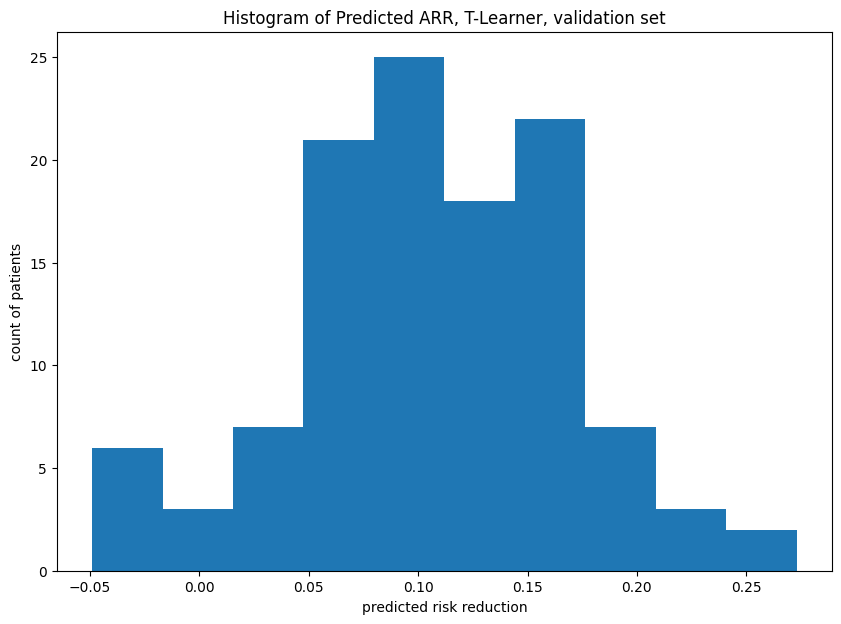

In [ ]:
plt.hist(rr_t_val, bins='auto')
plt.title("Histogram of Predicted ARR, T-Learner, validation set")
plt.xlabel('predicted risk reduction')
plt.ylabel('count of patients')
plt.show()

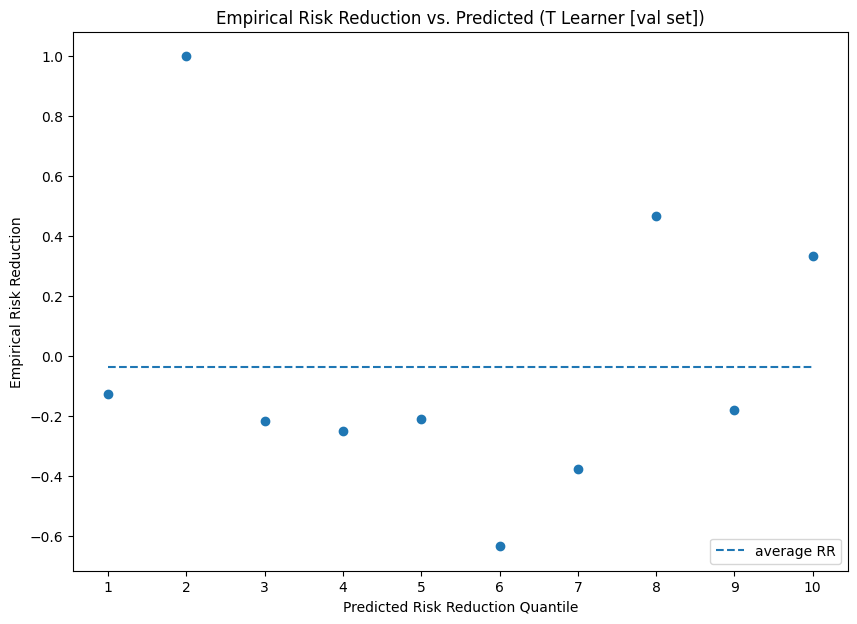

In [ ]:
empirical_benefit, avg_benefit = quantile_benefit(X_val, y_val, rr_t_val)
plot_empirical_risk_reduction(empirical_benefit, avg_benefit, 'T Learner [val set]')

In [ ]:
c_for_benefit_tlearner_val_set = c_statistic(rr_t_val, y_val, X_val.TRTMT)
print(f"C-for-benefit statistic of T-learner on val set: {c_for_benefit_tlearner_val_set:.4f}")

C-for-benefit statistic of T-learner on val set: 0.5043


In [ ]:
# predict the risk reduction for each of the patients in the test set
rr_t_test = t_learner.predict(X_test.drop(['TRTMT'], axis=1))

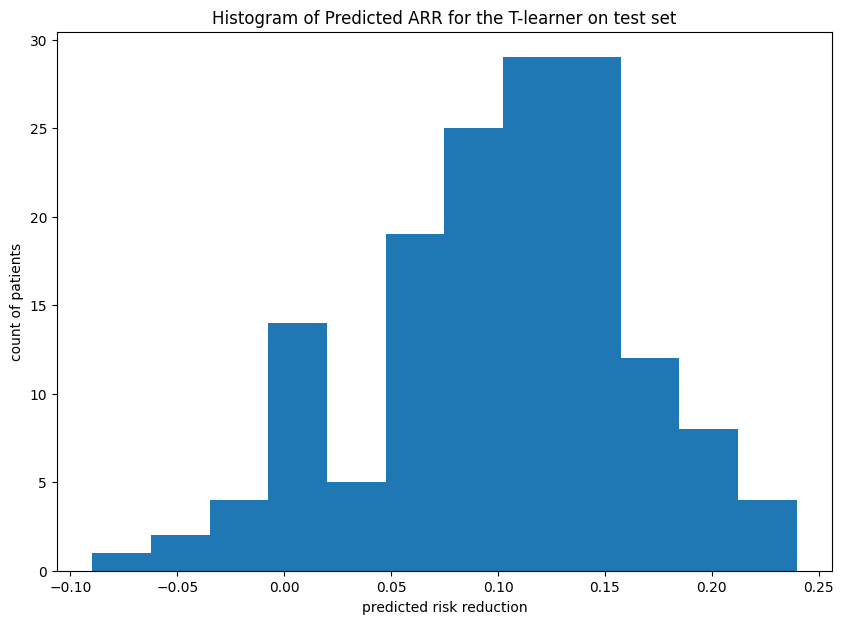

In [ ]:
# Plot a histogram of the predicted risk reduction
plt.hist(rr_t_test, bins='auto')
plt.title("Histogram of Predicted ARR for the T-learner on test set")
plt.xlabel("predicted risk reduction")
plt.ylabel("count of patients")
plt.show()

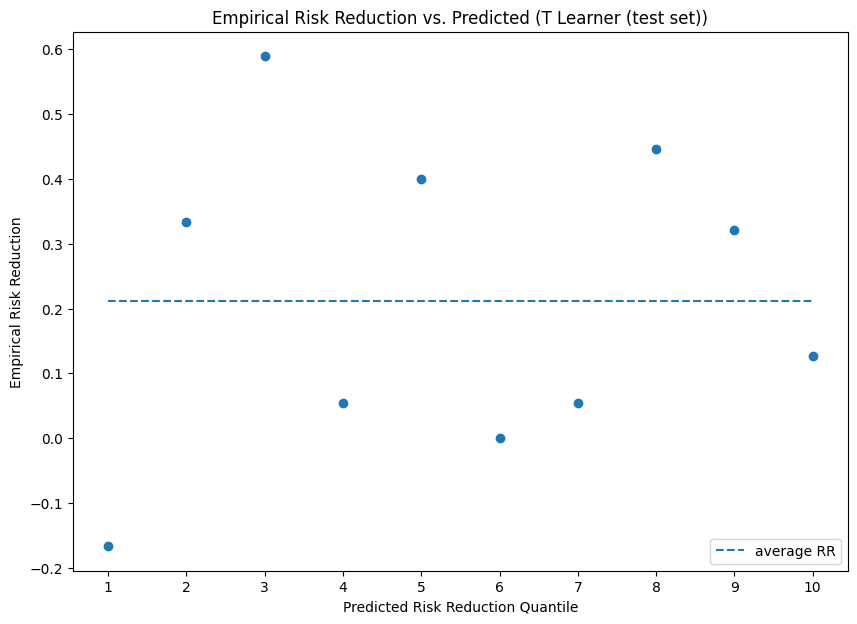

In [ ]:
# Plot the predicted versus empirical risk reduction for the test set
empirical_benefit, avg_benefit = quantile_benefit(X_test, y_test, rr_t_test)
plot_empirical_risk_reduction(empirical_benefit, avg_benefit, 'T Learner (test set)')

In [ ]:
# calculate the c-for-benefit of the t-learner on the test set
c_for_benefit_tlearner_test_set = c_statistic(rr_t_test, y_test, X_test.TRTMT)
print(f"C-for-benefit statistic on test set: {c_for_benefit_tlearner_test_set:.4f}")

C-for-benefit statistic on test set: 0.5250
